In [1]:
# Import necessary packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
import sklearn
import xgboost as xgb
import lime
import lime.lime_tabular
import warnings
from seaborn import countplot
from matplotlib import rcParams
from sklearn import ensemble
from sklearn import model_selection
from sklearn import metrics
from sklearn import preprocessing
from sklearn import pipeline
from xgboost import XGBClassifier
from lime import submodular_pick

In [2]:
# Read in the data from the CSV file

df = pd.read_csv('heart.csv')

In [3]:
# Determine number of rows and columns

df.shape

(918, 12)

In [4]:
# Get a snapshot of the first 5 rows of data

df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [5]:
# Understand non-null values and datatypes

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [6]:
# Drop rows for which blood pressure, cholesterol, and maximum heart rate values are 0.

df = df[(df[['RestingBP', 'Cholesterol', 'MaxHR']] != 0).all(1)]

df.shape

(746, 12)

In [7]:
# Aggregate missing values by column

df.isna().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [8]:
# Understand maximum, minimum values in the age column

df['Age'].describe()

count    746.000000
mean      52.882038
std        9.505888
min       28.000000
25%       46.000000
50%       54.000000
75%       59.000000
max       77.000000
Name: Age, dtype: float64

In [9]:
# Create 'Age_Decade' column that bins ages roughly by decade. Follows common health age group classification practices

df['Age_Decade'] = pd.cut(x=df['Age'], bins=[25, 34, 44, 54, 64, 74, 84], labels=['25-34', '35-44', '45-54', '55-64', '65-74', '75-84'])

array([[<AxesSubplot:title={'center':'RestingBP'}>,
        <AxesSubplot:title={'center':'Cholesterol'}>],
       [<AxesSubplot:title={'center':'MaxHR'}>,
        <AxesSubplot:title={'center':'Oldpeak'}>]], dtype=object)

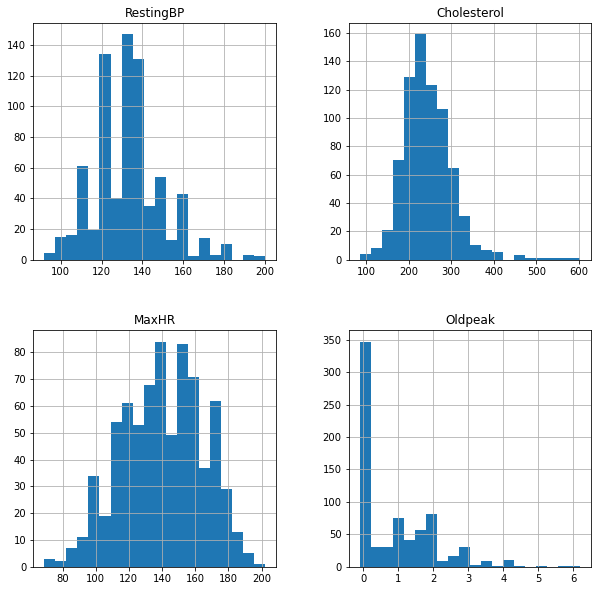

In [10]:
# Create histograms of columns containing numerical data (not categorical data)

df_numeric = df[['RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']]

df_numeric.hist(figsize=(10, 10), bins=20)

In [11]:
# Create new dataframe of only categorical data from the original dataset

df_categorical = df[['Age_Decade', 'Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope', 'HeartDisease']]

categorical_cols = list(df_categorical.columns)

In [12]:
# Understand the unique values in the categorical data columns - assessing cardinality

for col in df_categorical:
    print(col, df_categorical[col].unique())

Age_Decade ['35-44', '45-54', '55-64', '25-34', '65-74', '75-84']
Categories (6, object): ['25-34' < '35-44' < '45-54' < '55-64' < '65-74' < '75-84']
Sex ['M' 'F']
ChestPainType ['ATA' 'NAP' 'ASY' 'TA']
FastingBS [0 1]
RestingECG ['Normal' 'ST' 'LVH']
ExerciseAngina ['N' 'Y']
ST_Slope ['Up' 'Flat' 'Down']
HeartDisease [0 1]


In [13]:
# Rename certain values in categorical data columns for interpretability

df_categorical['FastingBS'] = df_categorical['FastingBS'].replace([0,1],['Below 120mg/dl', 'Above 120mg/dl'])
df_categorical['ExerciseAngina'] = df_categorical['ExerciseAngina'].replace(['N','Y'],['No', 'Yes'])
df_categorical['HeartDisease']= df_categorical['HeartDisease'].replace([0,1],['No', 'Yes'])


df['FastingBS'] = df['FastingBS'].replace([0,1],['Below 120mg/dl', 'Above 120mg/dl'])
df['ExerciseAngina'] = df['ExerciseAngina'].replace(['N','Y'],['No', 'Yes'])
df['HeartDisease']= df['HeartDisease'].replace([0,1],['No', 'Yes'])


<ipython-input-13-88148e0e8552>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_categorical['FastingBS'] = df_categorical['FastingBS'].replace([0,1],['Below 120mg/dl', 'Above 120mg/dl'])
<ipython-input-13-88148e0e8552>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_categorical['ExerciseAngina'] = df_categorical['ExerciseAngina'].replace(['N','Y'],['No', 'Yes'])
<ipython-input-13-88148e0e8552>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

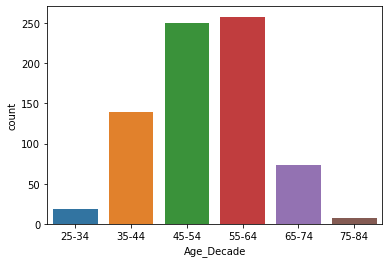

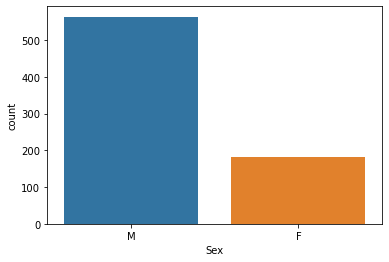

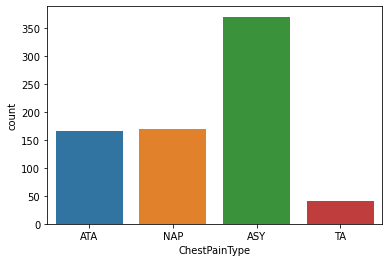

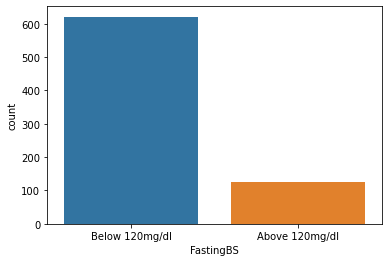

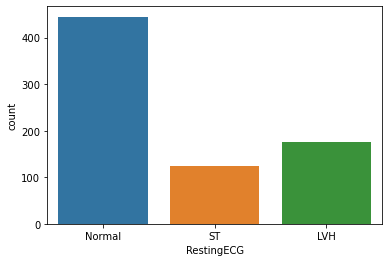

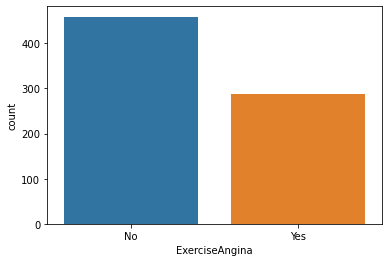

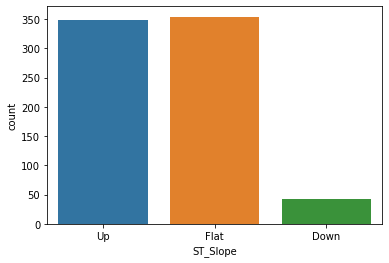

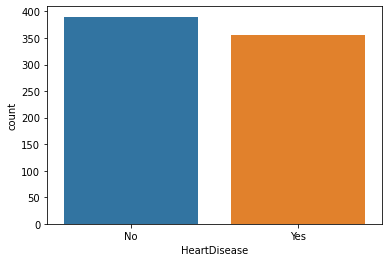

In [14]:
# Create count plots of categorical data columns

for col in categorical_cols:
    sns.countplot(x = col, data = df_categorical)
    plt.show()

<AxesSubplot:>

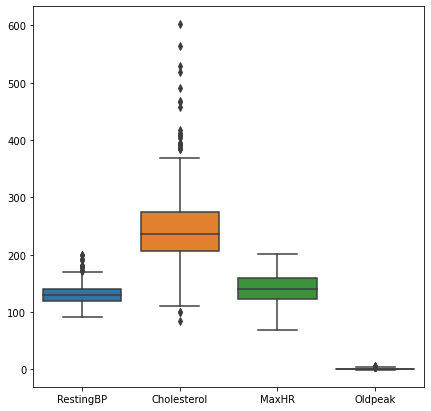

In [15]:
# Create a boxplot of numerical data columns

rcParams['figure.figsize'] = 7, 7

sns.boxplot(data=df_numeric)

<AxesSubplot:xlabel='Age', ylabel='RestingBP'>

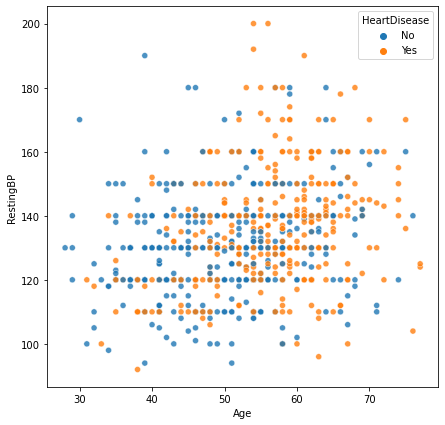

In [16]:
# Create a scatter plot to understand any relationship among the Age, RestingBP, and HeartDisease features

rcParams['figure.figsize'] = 7, 7

sns.scatterplot(data=df, x="Age", y="RestingBP", hue="HeartDisease", alpha=0.8)

<AxesSubplot:xlabel='Age', ylabel='Cholesterol'>

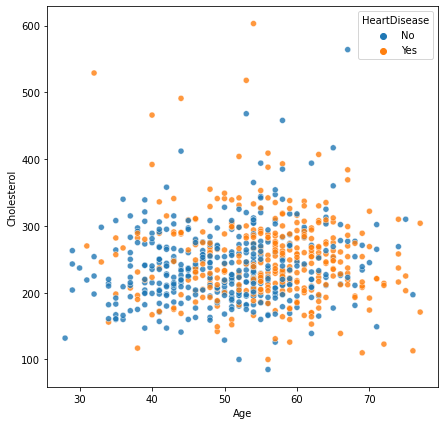

In [17]:
# Create a scatter plot to understand any relationship among the Age, Cholesterol, and HeartDisease features

rcParams['figure.figsize'] = 7, 7

sns.scatterplot(data=df, x="Age", y="Cholesterol", hue="HeartDisease", alpha=0.8)

In [18]:
# Drop rows in which numerical data is outside 3 standard deviations from the mean for that column

for col in df_numeric.columns:
    df_numeric = df_numeric[np.abs(df_numeric[col]-df_numeric[col].mean()) <= (3*df_numeric[col].std())]
    df[col] = df_numeric[col]
    
df = df.dropna()

In [19]:
# Group features for one-hot encoding

obj_cols = list(df.select_dtypes(include=object).columns)

obj_cols.remove('HeartDisease')

obj_cols.append('Age_Decade')

for col in obj_cols:
    print(col, df[col].unique())

Sex ['M' 'F']
ChestPainType ['ATA' 'NAP' 'ASY' 'TA']
FastingBS ['Below 120mg/dl' 'Above 120mg/dl']
RestingECG ['Normal' 'ST' 'LVH']
ExerciseAngina ['No' 'Yes']
ST_Slope ['Up' 'Flat' 'Down']
Age_Decade ['35-44', '45-54', '55-64', '25-34', '65-74', '75-84']
Categories (6, object): ['25-34' < '35-44' < '45-54' < '55-64' < '65-74' < '75-84']


In [20]:
# Perform one-hot encoding

df = pd.get_dummies(df, columns=list(obj_cols))

In [21]:
# Drop the age column. Print column names for the updated dataframe

df = df.drop(columns=['Age'])

df.columns

Index(['RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak', 'HeartDisease', 'Sex_F',
       'Sex_M', 'ChestPainType_ASY', 'ChestPainType_ATA', 'ChestPainType_NAP',
       'ChestPainType_TA', 'FastingBS_Above 120mg/dl',
       'FastingBS_Below 120mg/dl', 'RestingECG_LVH', 'RestingECG_Normal',
       'RestingECG_ST', 'ExerciseAngina_No', 'ExerciseAngina_Yes',
       'ST_Slope_Down', 'ST_Slope_Flat', 'ST_Slope_Up', 'Age_Decade_25-34',
       'Age_Decade_35-44', 'Age_Decade_45-54', 'Age_Decade_55-64',
       'Age_Decade_65-74', 'Age_Decade_75-84'],
      dtype='object')

In [22]:
# Aggregate missing values by column

df.isna().sum()

RestingBP                   0
Cholesterol                 0
MaxHR                       0
Oldpeak                     0
HeartDisease                0
Sex_F                       0
Sex_M                       0
ChestPainType_ASY           0
ChestPainType_ATA           0
ChestPainType_NAP           0
ChestPainType_TA            0
FastingBS_Above 120mg/dl    0
FastingBS_Below 120mg/dl    0
RestingECG_LVH              0
RestingECG_Normal           0
RestingECG_ST               0
ExerciseAngina_No           0
ExerciseAngina_Yes          0
ST_Slope_Down               0
ST_Slope_Flat               0
ST_Slope_Up                 0
Age_Decade_25-34            0
Age_Decade_35-44            0
Age_Decade_45-54            0
Age_Decade_55-64            0
Age_Decade_65-74            0
Age_Decade_75-84            0
dtype: int64

In [23]:
# Revisit HeartDisease column - change values back to 0 and 1 for modeling. Split data into X and y dataframes.

df_y = df['HeartDisease'].replace(['No', 'Yes'],[0,1])


df_X = df.drop(columns=['HeartDisease'])

In [24]:
# Split data into training and testing datasets

X_train, X_test, y_train, y_test = model_selection.train_test_split(df_X, df_y, test_size=0.33, random_state=42, stratify=df_y)

In [25]:
# Determine splitting between HeartDisease and No HeartDisease in y dataframe

df_y.value_counts()/len(df_y)

0    0.529574
1    0.470426
Name: HeartDisease, dtype: float64

In [26]:
# Assess stratification of target variable classes in training and testing datasets

print(y_train.value_counts()/len(y_train))

print(y_test.value_counts()/len(y_test))

0    0.529774
1    0.470226
Name: HeartDisease, dtype: float64
0    0.529167
1    0.470833
Name: HeartDisease, dtype: float64


In [27]:
# Set up scaling and XGBoost pipeline

model_x = xgb.XGBClassifier(objective='binary:logistic', eval_metric='aucpr', seed=42, use_label_encoder=False)

xgb_pipe = pipeline.Pipeline([
    ('scaler', preprocessing.StandardScaler()), 
    ('classifier', model_x)
])

xgb_pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, enable_categorical=False,
                               eval_metric='aucpr', gamma=0, gpu_id=-1,
                               importance_type=None, interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=8, num_parallel_tree=1, predictor='auto',
                               random_state=42, reg_alpha=0, reg_lambda=1,
                               scale_pos_weight=1, seed=42, subsample=1,
                               tree_method='exact', use_label_encoder=False,
                      

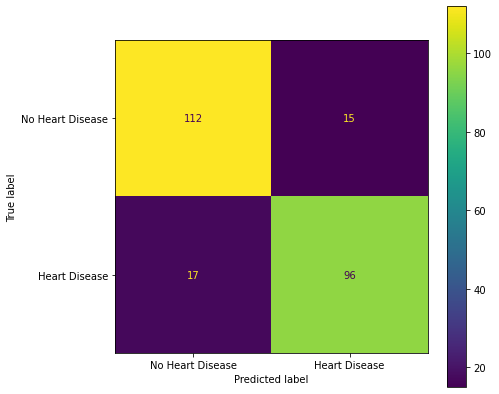

In [28]:
# Print confusion matrix for XGBoost model

xgb_pred = xgb_pipe.predict(X_test)
cm = metrics.confusion_matrix(y_test, xgb_pred, labels=xgb_pipe.classes_)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, 
                                      display_labels=['No Heart Disease', 'Heart Disease'])
disp.plot()
plt.show()

In [29]:
# Print precision and recall metrics

xgb_precision = metrics.precision_score(y_test, xgb_pred)
xgb_recall = metrics.recall_score(y_test, xgb_pred)

print('XGBoost Model Precision:', format(xgb_precision, '.1%'), '\nXGBoost Model Recall: ', format(xgb_recall, '.1%'))

XGBoost Model Precision: 86.5% 
XGBoost Model Recall:  85.0%


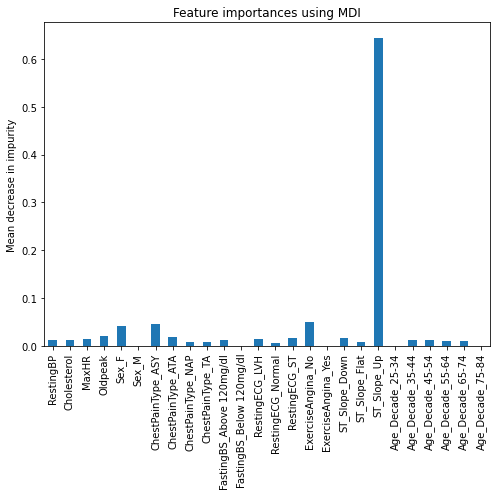

In [30]:
# Estimate feature importance using mean decrease in impurity

feature_names = df_X.columns
importances = model_x.feature_importances_

forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [31]:
# Create object of LimeTabularExplainer class, fit to training data

explainer = lime.lime_tabular.LimeTabularExplainer(training_data=np.array(X_train), 
                                                   mode='classification',
                                                   feature_names=df_X.columns,
                                                   categorical_features=[5, len(X_train.columns)],
                                                   verbose=True,
                                                   random_state=42)

In [32]:
# Use LimeTabularExplainer to explain one instance of testing data

exp = explainer.explain_instance(data_row=X_test.iloc[3], 
                                 predict_fn=xgb_pipe.predict_proba, 
                                 num_features=5)

exp.show_in_notebook(show_table=True)

Intercept 0.6292792441907499
Prediction_local [-0.06479101]
Right: 0.030470926


In [33]:
# Code for SP-LIME, which returns exaplanations on a sample set to provide a non redundant global decision boundary of original model

sp_obj_xgb = submodular_pick.SubmodularPick(explainer, X_train.values, xgb_pipe.predict_proba, sample_size=100, num_features=10, num_exps_desired=5)

Intercept -0.2501953949188451
Prediction_local [1.10433279]
Right: 0.998858
Intercept 0.051498946741903084
Prediction_local [0.7488132]
Right: 0.9806896
Intercept 0.11967047124802677
Prediction_local [0.84240622]
Right: 0.9808648
Intercept -0.16609157558896837
Prediction_local [0.99991856]
Right: 0.99350595
Intercept 0.9927472825629604
Prediction_local [0.38015615]
Right: 0.9281815
Intercept -0.1417302547150886
Prediction_local [0.86432004]
Right: 0.9891488
Intercept 0.08715402534692396
Prediction_local [1.31535064]
Right: 0.9984769
Intercept -0.06722582812056793
Prediction_local [1.00389887]
Right: 0.98378885
Intercept -0.049791946186771296
Prediction_local [0.83472483]
Right: 0.99663347
Intercept 0.5956429300798414
Prediction_local [0.45400375]
Right: 0.9979135
Intercept 0.7603692221985436
Prediction_local [0.29129613]
Right: 0.9391684
Intercept -0.07464219290100671
Prediction_local [1.27579084]
Right: 0.9999384
Intercept 0.2123524685408063
Prediction_local [1.01078383]
Right: 0.9997

[<Figure size 504x504 with 1 Axes>,
 <Figure size 504x504 with 1 Axes>,
 <Figure size 504x504 with 1 Axes>,
 <Figure size 504x504 with 1 Axes>,
 <Figure size 504x504 with 1 Axes>]

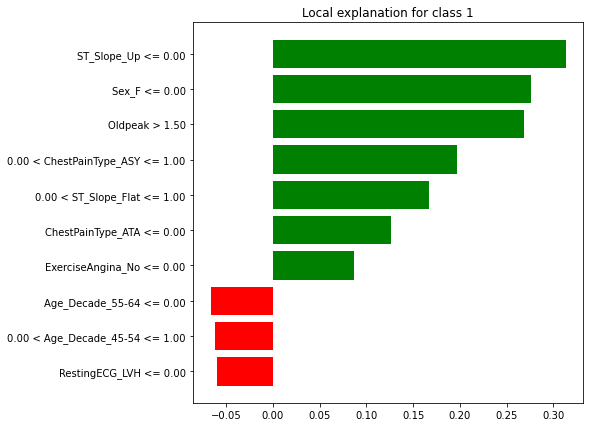

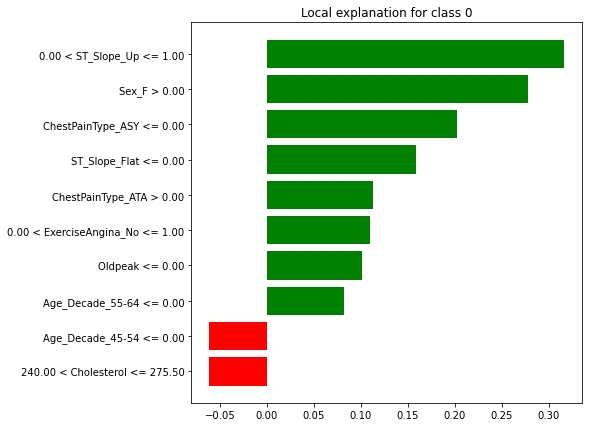

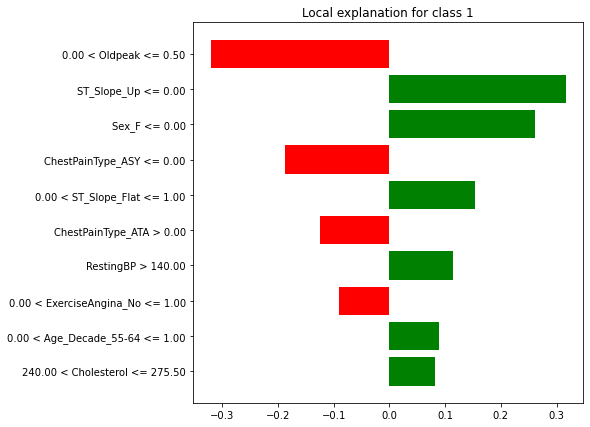

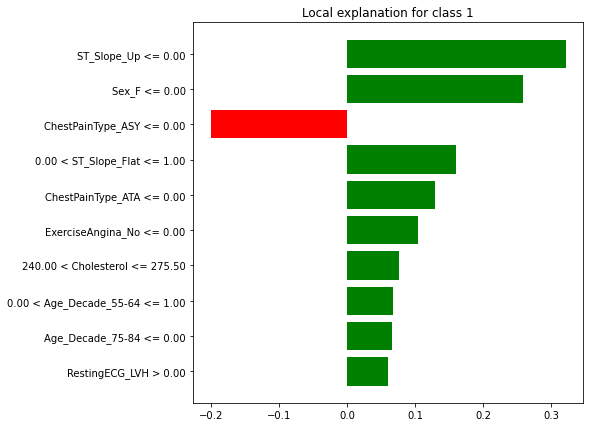

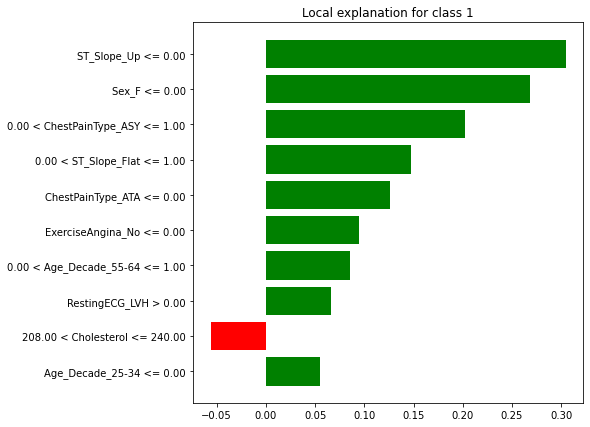

In [34]:
# Plot explainations for representative samples

[exp.as_pyplot_figure(label=exp.available_labels()[0]) for exp in sp_obj_xgb.sp_explanations]



In [35]:
# Set up a RandomForestClassifier pipeline

model_r = ensemble.RandomForestClassifier(max_depth = 10,
                                          min_samples_leaf = 3,
                                          min_samples_split = 4,
                                          n_estimators = 200)

rfc_pipe = pipeline.Pipeline([
     ('scaler', preprocessing.StandardScaler()), 
     ('classifier', model_r)
])

rfc_pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier',
                 RandomForestClassifier(max_depth=10, min_samples_leaf=3,
                                        min_samples_split=4,
                                        n_estimators=200))])

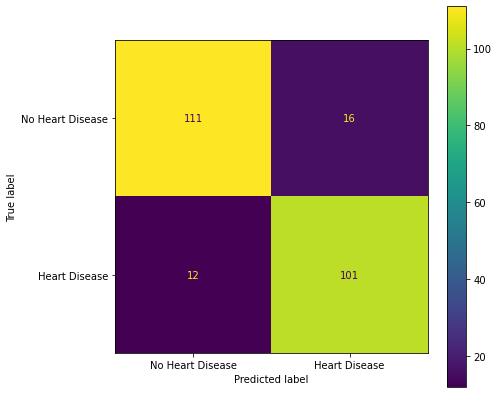

In [36]:
# Print confusion matrix for RandomForestClassifier model

rfc_pred = rfc_pipe.predict(X_test)
cm = metrics.confusion_matrix(y_test, rfc_pred, labels=rfc_pipe.classes_)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, 
                                      display_labels=['No Heart Disease', 'Heart Disease'])
disp.plot()
plt.show()

In [37]:
# Print precision and recall metrics

rfc_precision = metrics.precision_score(y_test, rfc_pred)
rfc_recall = metrics.recall_score(y_test, rfc_pred)

print('RandomForestClassifier Model Precision:', format(rfc_precision, '.1%'), '\nRandomForestClassifier Model Recall: ', format(rfc_recall, '.1%'))

RandomForestClassifier Model Precision: 86.3% 
RandomForestClassifier Model Recall:  89.4%


In [38]:
# Use LimeTabularExplainer to explain one instance of testing data

exp_rfc = explainer.explain_instance(data_row=X_test.iloc[3], 
                                    predict_fn=rfc_pipe.predict_proba, 
                                    num_features=5)

exp.show_in_notebook(show_table=True)

Intercept 0.7006158162787947
Prediction_local [0.24032549]
Right: 0.17659075957847445


In [39]:
# Code for SP-LIME, which returns exaplanations on a sample set to provide a non redundant global decision boundary of original model

sp_obj_rfc = submodular_pick.SubmodularPick(explainer, X_train.values, rfc_pipe.predict_proba, sample_size=100, num_features=10, num_exps_desired=5)

Intercept 0.3747505158018413
Prediction_local [0.79354481]
Right: 0.8328296251412404
Intercept 0.28613953637083867
Prediction_local [0.82987659]
Right: 0.9754756827354752
Intercept 0.26247302467696876
Prediction_local [0.89428454]
Right: 0.9944497803414307
Intercept -0.04173992606294774
Prediction_local [1.0009027]
Right: 0.9703631015987995
Intercept 0.2923434095378375
Prediction_local [0.86237199]
Right: 0.7731406577955423
Intercept 0.2577006280351793
Prediction_local [0.58723234]
Right: 0.7795723134530935
Intercept 0.16706828902011284
Prediction_local [0.68159049]
Right: 0.9067043036724689
Intercept 0.09712832507576208
Prediction_local [0.82193692]
Right: 0.9100729016354018
Intercept 0.3051393383228273
Prediction_local [0.5803496]
Right: 0.5169175640181074
Intercept 0.33544741749058865
Prediction_local [0.82475699]
Right: 0.8510557073019804
Intercept 0.3384042203861734
Prediction_local [0.8276461]
Right: 0.9309394914998497
Intercept -0.03541126031572678
Prediction_local [0.9890474]
R

Intercept 0.46563800534259353
Prediction_local [0.68791304]
Right: 0.9464011809503695
Intercept 0.7227488761884779
Prediction_local [0.35926756]
Right: 0.5996669788966951
Intercept -0.047522688368910215
Prediction_local [0.9681609]
Right: 0.9625124881132037
Intercept 0.31798543342848645
Prediction_local [0.81722588]
Right: 0.9505543814737895


[<Figure size 504x504 with 1 Axes>,
 <Figure size 504x504 with 1 Axes>,
 <Figure size 504x504 with 1 Axes>,
 <Figure size 504x504 with 1 Axes>,
 <Figure size 504x504 with 1 Axes>]

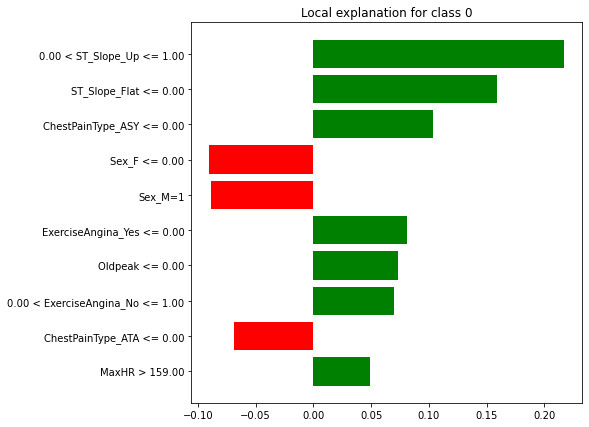

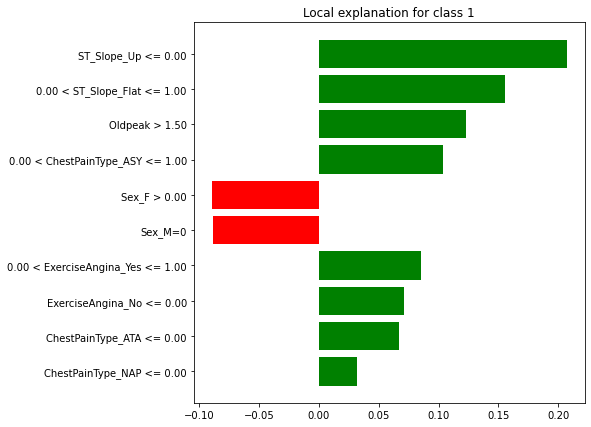

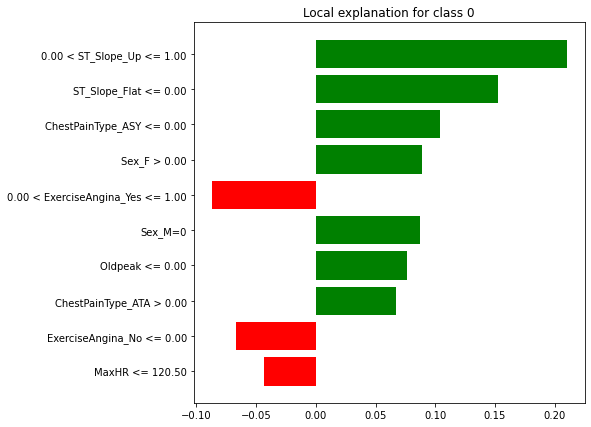

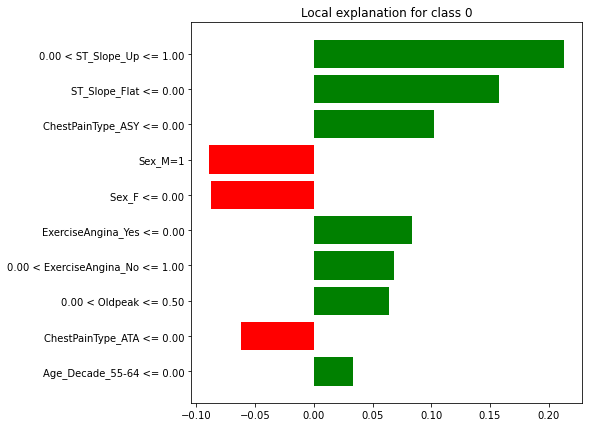

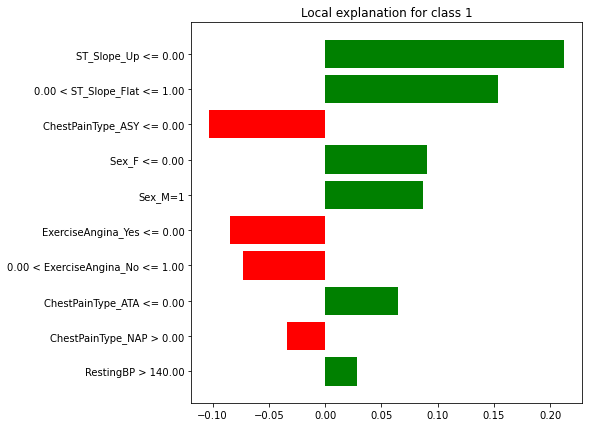

In [40]:
# Plot explainations for representative samples

[exp.as_pyplot_figure(label=exp.available_labels()[0]) for exp in sp_obj_rfc.sp_explanations]